# Music Recommendation

## Table of Contents

1. Data Preprocessing 

2. Data Exploration 

3. Model Building

4. Making Recommendations

---

## 1. Data Preprocessing

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
# -- 
from surprise import Dataset, SVD
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
import pandas as pd
from surprise import accuracy
from surprise import BaselineOnly
from surprise.model_selection import GridSearchCV

In [87]:
# load the user dataset
column_names = ['user_id', 'song_id', 'play_count']
df = pd.read_csv("kaggle_visible_evaluation_triplets.txt", sep='\t', names=column_names)
df.head()
df = df.sample(100000, random_state=42)
len(df)

100000

In [88]:
# my songs dataset 
mydf = pd.read_csv("my_songs.csv", sep = '\t')
mydf

,user_id,song_id,play_count
0,namtr,SOJBAOJ12A8AE47050,10
1,namtr,SODFGUC12AB0184AF7,10
2,namtr,SOXRWWP127CF8DC9B2,10
3,namtr,SOLWGXS12A6701EDB5,10
4,namtr,SODGVGW12AC9075A8D,10
5,boshen,SOBONKR12A58A7A7E0,10
6,boshen,SOVDSJC12A58A7A271,10
7,boshen,SOBRHVR12A8C133F35,10
8,boshen,SOMGVYU12A8C1314FF,10
9,boshen,SOVLNXV12A6D4F706E,10


In [89]:
# merge my songs with the user dataset
df = pd.concat([df,mydf],axis=0)
df.head()

,user_id,song_id,play_count
977672,d131ba7aca253a01adf49d47b0b60736e3bcd578,SOJZUBF12A8C13B5D2,1
447130,8640529f5f21ddc41db0185d36f81d39ccf70909,SOFFEUI12A8C142F4E,2
943690,ed4581c5d05af39780b99eea3dad480be186ec6f,SOYAIPB12A8C143D84,1
592194,25ad9ea0366e4e39ac188266a73e4e643538108d,SOWMTMB12A6D4F81DE,1
540101,9ba7a75bcc0016f62e819551d02e5a0a01e0e632,SOVIZNF12AF72A710A,1


In [90]:
# import track dataset 
df_tracks = pd.read_csv('unique_tracks.txt',
                       sep='<SEP>', names=['track_id','song_id','artist_name','song'], engine='python')
df_tracks.head()

,track_id,song_id,artist_name,song
0,TRMMMYQ128F932D901,SOQMMHC12AB0180CB8,Faster Pussy cat,Silent Night
1,TRMMMKD128F425225D,SOVFVAK12A8C1350D9,Karkkiautomaatti,Tanssi vaan
2,TRMMMRX128F93187D9,SOGTUKN12AB017F4F1,Hudson Mohawke,No One Could Ever
3,TRMMMCH128F425532C,SOBNYVR12A8C13558C,Yerba Brava,Si Vos Querés
4,TRMMMWA128F426B589,SOHSBXH12A8C13B0DF,Der Mystic,Tangle Of Aspens


In [91]:
# Merge
merged_df = pd.merge(df, df_tracks.drop_duplicates(['song_id']), how='left', on='song_id')
merged_df.head()

,user_id,song_id,play_count,track_id,artist_name,song
0,d131ba7aca253a01adf49d47b0b60736e3bcd578,SOJZUBF12A8C13B5D2,1,TRKUNSX128F42952DA,Jason Mraz,After An Afternoon (Eagles Ballroom Live Version)
1,8640529f5f21ddc41db0185d36f81d39ccf70909,SOFFEUI12A8C142F4E,2,TRGUXUV12903D05329,Joshua Radin,Free Of Me
2,ed4581c5d05af39780b99eea3dad480be186ec6f,SOYAIPB12A8C143D84,1,TRWDPTD12903D018B5,Justin Timberlake,Cry Me A River
3,25ad9ea0366e4e39ac188266a73e4e643538108d,SOWMTMB12A6D4F81DE,1,TRZITSJ128F148CF24,Sister Hazel,Happy
4,9ba7a75bcc0016f62e819551d02e5a0a01e0e632,SOVIZNF12AF72A710A,1,TRHNBHR128F9350E67,The Prodigy,The Big Gundown


## 2. Data Exploration

In [92]:
# Define bins and labels
bins = [1, 2, 3, 4, 5,6,7,8,9,10, float('inf')]  
labels = [1, 2, 3, 4, 5,6,7,8,9,10]  

# Bin the 'play_count' column
merged_df['play_count_binned'] = pd.cut(merged_df['play_count'], bins=bins, labels=labels, right=False)
merged_df['play_count_binned'].value_counts()

play_count_binned
1     57901
2     14665
3      6614
10     6238
5      5050
4      3788
6      2251
7      1527
8      1132
9       844
Name: count, dtype: int64

In [93]:
print(f"No. of unique users: {merged_df['user_id'].nunique()}")
print(f"No. of unique songs: {merged_df['song_id'].nunique()}")
print(f"No. of unique play counts: {merged_df['play_count'].nunique()}")

No. of unique users: 61136
No. of unique songs: 41495
No. of unique play counts: 142


`Find the most popular artists based on the number of total unique users`

In [94]:
popular = merged_df[['artist_name','user_id']]

# remove duplicate rows because of the same user listening to the same artist multiple times
popular = popular.drop_duplicates()

artist_pop = popular.pivot_table(values=['user_id'],index = 'artist_name' ,aggfunc = 'count') 

artist_pop = artist_pop.reset_index()

artist_pop = artist_pop.sort_values(by='user_id',ascending=False)

artist_pop.rename(columns = {'artist_name':'Artist', 'user_id':'Total Unique Listeners'}, inplace = True)

artist_pop.head(10)

,Artist,Total Unique Listeners
2400,Coldplay,795
4126,Florence + The Machine,571
6320,Kings Of Leon,563
6015,Justin Bieber,499
12328,Train,469
3700,Eminem,410
8562,OneRepublic,409
5282,Jack Johnson,407
11107,The Black Keys,398
6819,Linkin Park,375


`Most popular songs` 

In [95]:
popular = merged_df[['artist_name','song','play_count']]

artist_pop = popular.pivot_table(values=['play_count'],index = ['artist_name','song'] ,aggfunc = 'sum')

artist_pop = artist_pop.sort_values(by='play_count',ascending=False)

artist_pop = artist_pop.reset_index()

artist_pop[['song', 'artist_name', 'play_count']].head(10)

,song,artist_name,play_count
0,Undo,Björk,2427
1,You're The One,Dwight Yoakam,2384
2,Horn Concerto No. 4 in E flat K495: II. Romanc...,Barry Tuckwell/Academy of St Martin-in-the-Fie...,1680
3,Revelry,Kings Of Leon,1486
4,Sehr kosmisch,Harmonia,1249
5,Dog Days Are Over (Radio Edit),Florence + The Machine,982
6,Secrets,OneRepublic,951
7,Ain't Misbehavin,Sam Cooke,850
8,Recado Falado (Metrô Da Saudade),Alceu Valença,829
9,Représente,Alliance Ethnik,820


`Question 1:` What users listen the most? how many play counts, how many unique songs? 

In [96]:
top_user = merged_df[['user_id','play_count','song_id']]

# calculate the the total play count for each user and total number of song_id they listened to 
top_user = top_user.groupby('user_id').agg({'play_count':'sum','song_id':'count'}).reset_index()

top_user.rename(columns = {'play_count':'Total_Play_Count','song_id':'Total_Song_Count'}, inplace = True)

top_user = top_user.sort_values(by='Total_Play_Count',ascending=False)

In [97]:
# select the top 5 only 
top_user = top_user.head(5)

print('Here is the top users that listen to the most songs and their total play count, number of songs they listen to:')
top_user

Here is the top users that listen to the most songs and their total play count, number of songs they listen to:


,user_id,Total_Play_Count,Total_Song_Count
26152,6e2e840f6e717c883efec5115e1f25bb805765c1,454,1
21194,590e425afafecf7953765c2873865519e7f80343,434,2
10494,2bb4f982c96ceef1f1965a762201b76983af9f0b,353,3
49317,cf0f33c580293de446dd4dc27da1793565f30ee4,335,1
42773,b371df81acfde601d157a99c50fa06f7b3f76a84,334,5


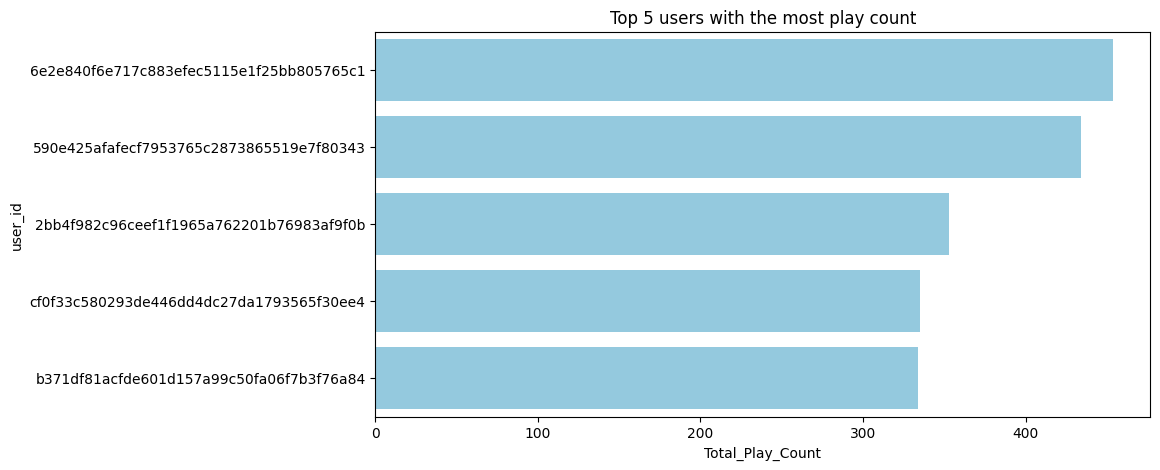

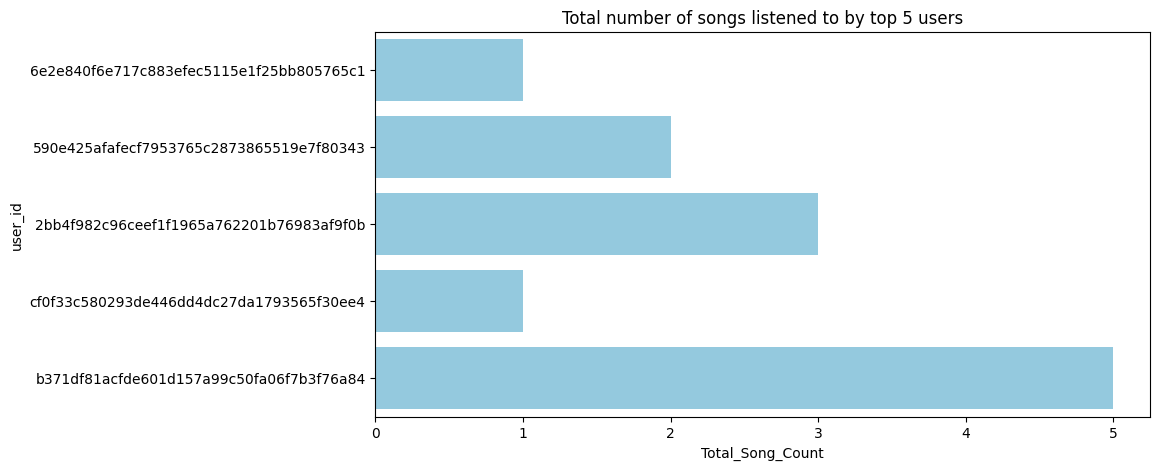

In [98]:
# visualize top 5 users with the most play count and their number of play counts and number of songs they listened to
plt.figure(figsize=(10,5))
sns.barplot(y='user_id',x='Total_Play_Count',data=top_user, color = 'skyblue')
plt.title('Top 5 users with the most play count')
plt.show()

# visualize top 5 users with the most play count and their number of play counts and number of songs they listened to
plt.figure(figsize=(10,5))
sns.barplot(y='user_id',x='Total_Song_Count',data=top_user, color = 'skyblue')
plt.title('Total number of songs listened to by top 5 users')
plt.show()

In [99]:
print('These are the songs listened to by the top 5 users with the most play count: \n')
for user in top_user['user_id']:
    print(merged_df[merged_df['user_id'] == user][['song','play_count']].sort_values(by='play_count',ascending=False).head(10))
    print("\n")

These are the songs listened to by the top 5 users with the most play count: 

                  song  play_count
44711  Better Together         454


                      song  play_count
21091  Rain On Your Parade         433
90931     Scarborough Fair           1


                                   song  play_count
47938  Recado Falado (Metrô Da Saudade)         348
60100                        Gunn Clapp           4
49657                           Invalid           1


        song  play_count
40802  Sorry         335


                                                    song  play_count
86540                                   Divide & Conquer         136
98296                                This Is Not My Life          91
18236  Remember Me (Contains Hidden Track 'Fatal Fact...          77
79805                                      Draw Me Close          29
7938                                         Winter Song           1




`Question 2:` What are the most popular songs and artist? How many unique users have listened to them?

- Here I define most popular songs as songs that have the most play counts, while most popular artists are artists that have the most unique listeners.
- Some may also argue that the most popular artists are those that have the most play counts, so I produce visualizations for both cases

In [100]:
popular = merged_df[['artist_name','song','play_count','user_id']]

pop_song = popular.pivot_table(values=['play_count','user_id'],index = ['artist_name','song'] ,aggfunc = {'play_count':'sum','user_id':'count'})

pop_song.reset_index(inplace=True)

# sort by play count, and number of unique users
pop_song = pop_song.sort_values(by=['play_count','user_id'],ascending=False)

# rename columns
pop_song.rename(columns = {'artist_name':'Artist', 'song':'Song', 'play_count':'Total_Play_Count','user_id':'Total_Unique_Users'}, inplace = True)
pop_song.head()


,Artist,Song,Total_Play_Count,Total_Unique_Users
4460,Björk,Undo,2427,302
11085,Dwight Yoakam,You're The One,2384,282
3411,Barry Tuckwell/Academy of St Martin-in-the-Fie...,Horn Concerto No. 4 in E flat K495: II. Romanc...,1680,240
20061,Kings Of Leon,Revelry,1486,253
15464,Harmonia,Sehr kosmisch,1249,361


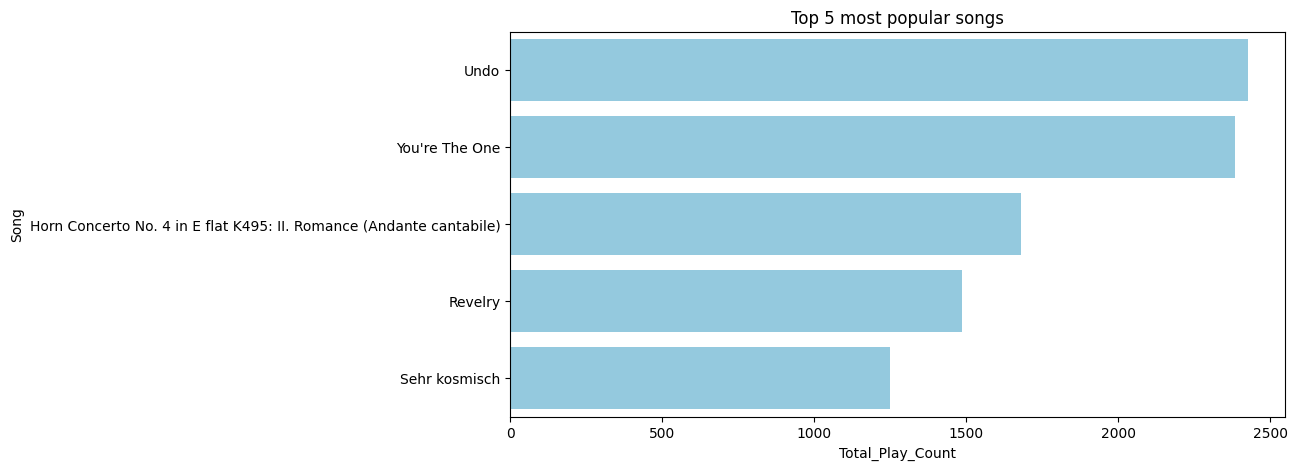

In [101]:
# visualize the top 5 songs with the most play count
plt.figure(figsize=(10,5))

sns.barplot(x='Total_Play_Count',y='Song',data=pop_song.head(5), color = 'skyblue')
# include a second bar for the number of unique users

plt.title('Top 5 most popular songs')

plt.show()


<Figure size 2000x500 with 0 Axes>

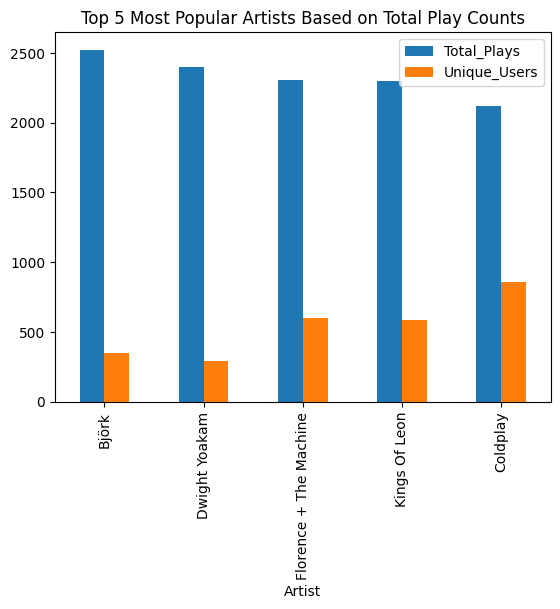

In [102]:
# Visualize popular aritsts based on the total play counts
artist_pop = merged_df.groupby('artist_name').agg({'play_count': ['sum', 'count']}).reset_index()

artist_pop.columns = ['Artist', 'Total_Plays', 'Unique_Users'] 

# Sort by total play in descending order
artist_pop = artist_pop.sort_values(by='Total_Plays', ascending=False)

artist_pop = artist_pop.reset_index(drop=True).head(5)

plt.figure(figsize=(20,5))

artist_pop.plot(x='Artist', y=['Total_Plays', 'Unique_Users'], kind='bar')

plt.title('Top 5 Most Popular Artists Based on Total Play Counts')

plt.show()

<Figure size 2000x500 with 0 Axes>

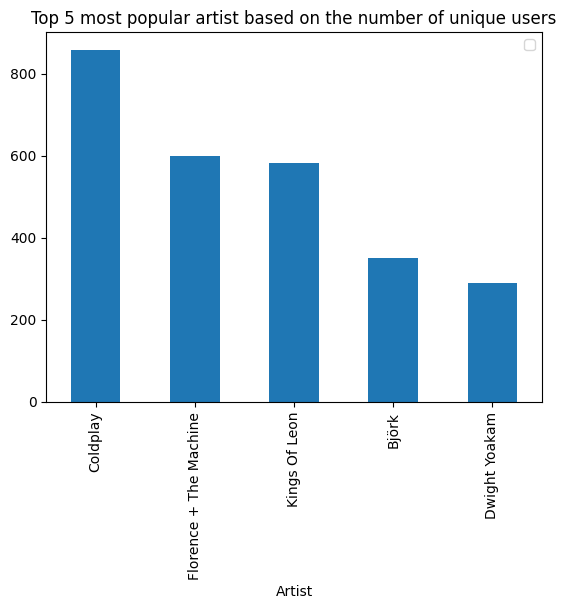

In [103]:
# Top 5 popular artists based on the number of unique users

artist_pop = artist_pop.sort_values(by='Unique_Users', ascending=False)

artist_pop = artist_pop.reset_index(drop=True).head(5)

plt.figure(figsize=(20,5))

artist_pop.plot(x='Artist', y='Unique_Users', kind='bar')

plt.title('Top 5 most popular artist based on the number of unique users')

plt.legend('')

plt.show()

In [19]:
print('Here is the table of the top 5 most popular artists based on the total of unique listeners and total play counts: \n')
artist_pop

Here is the table of the top 5 most popular artists based on the total of unique listeners and total play counts: 



,Artist,Total_Plays,Unique_Users
0,Coldplay,2119,858
1,Florence + The Machine,2308,600
2,Kings Of Leon,2302,583
3,Björk,2522,351
4,Dwight Yoakam,2396,290


*Analysis for these EDA are provided in the executive summary* 

## 3. Model Building

Overview:
- 3.1 BaselineOnly - method of surprise 
- 3.2 SVD
- 3.3 SVD Tuned with GridSearchCV

### 3.1 Baseline Algorithm

For the first model, we will buid the baseline algorithm

In [20]:
# prepare dataset
reader = Reader(rating_scale=(merged_df['play_count_binned'].min(),
                              merged_df['play_count_binned'].max()))
data = Dataset.load_from_df(merged_df[['user_id','song_id','play_count_binned']], reader)


# test set is made of 30% of the ratings.
trainset, testset = train_test_split(data,test_size=0.3)


In [21]:
# overview of the trainset
print('user count.: ', trainset.n_users)
print('item count.: ', trainset.n_items)
print('rating count.: ', trainset.n_ratings)
print('rating range: ', trainset.rating_scale)

user count.:  48673
item count.:  32968
rating count.:  70007
rating range:  (1, 10)


To make life easy, I will create a class to store evaluation metrics of all the built models

In [22]:
class ModelMetrics:
    def __init__(self, model, testset):
        self.model = model
        self.testset = testset
        self.predictions = model.test(testset)
        self.rmse = accuracy.rmse(self.predictions, verbose=False).round(4)
        self.mae = accuracy.mae(self.predictions, verbose=False).round(4)

In [23]:
# Define and train the BaselineOnly model
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 3,
               'reg_i': 15} 
algo_global = BaselineOnly(bsl_options=bsl_options)
algo_global.fit(trainset)


Estimating biases using als...


In [24]:
print("Evaluating Global Mean Baseline:")
bsl_metrics = ModelMetrics(algo_global, testset)
print("RMSE: ", bsl_metrics.rmse)
print("MAE: ", bsl_metrics.mae)

Evaluating Global Mean Baseline:
RMSE:  2.4731
MAE:  1.8222


### 3.2 Singular Value Decomposition (SVD)

In [25]:
# Use the SVD algorithm
svd_model = SVD(
    n_epochs = 20,
    lr_all = 0.005,
    n_factors =  50,
    reg_all =  0.1
)

# Train the algorithm on the trainset
svd_model.fit(trainset)

In [26]:
# evaluate the SVD model 
print("Evaluating Non Tuned SVD Model:")
svd_metrics = ModelMetrics(svd_model, testset)
print("RMSE: ", svd_metrics.rmse)
print("MAE: ", svd_metrics.mae)


Evaluating Non Tuned SVD Model:
RMSE:  2.4962
MAE:  1.8547


Ir appears that both RMSE and MAE of SVD model are higher than the baseline model. However, the difference is not significant.
- To further enhance the model performance, we can attempt to tune the hyperparameters of the SVD model using GridSearchCV.


### 3.3 Fine Tuning SVD with GridSearchCV

#### 3.3.1 Tuning 1

In [27]:
param_grid = {
    'n_factors': [30, 50, 100, 150],
    'n_epochs': [10, 20],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.05, 0.09]
}

gs = GridSearchCV(SVD, 
                  param_grid, 
                  measures=['RMSE', 'MAE'], 
                  cv=5, 
                  n_jobs=-1)

gs.fit(data)

# best RMSE score on the dataset

print(f"RMSE best score of the first tuned SVD: {gs.best_score['rmse']}")

print(f'Here is the combination of hyperparameters that gave the best RMSE score: \n')
print(gs.best_params['rmse'])


RMSE best score of the first tuned SVD: 2.5009184850417623
Here is the combination of hyperparameters that gave the best RMSE score: 

{'n_factors': 30, 'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.09}


RMSE for the tunned SVD model is better than the non-tunned one. This is a good sign!

However, based on the selected hyperparameters, the some of the hyperparameters are at the edge of the range. This means that we can extend the range to further tune the hyperparameters to get a better model performance.



In [28]:
param_grid = {
    'n_factors': [30, 50, 60, 80],
    'n_epochs': [15, 20, 25],
    'lr_all': [0.005, 0.01,0.03],
    'reg_all': [0.05, 0.09, 0.15]
}

gs = GridSearchCV(SVD, param_grid, measures=['RMSE', 'MAE'], cv=5, n_jobs=-1)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])


2.4951528272923666
{'n_factors': 80, 'n_epochs': 25, 'lr_all': 0.03, 'reg_all': 0.15}


There are still rooms for improvement. All hyperparameters are still at the edge of the range. We can further extend the range to get a better model performance.

#### 3.3.2 Tuning 2

In [29]:
param_grid = {
    'n_factors': [60, 80, 90, 100],
    'n_epochs': [15, 20, 30],
    'lr_all': [0.01,0.03, 0.05],
    'reg_all': [ 0.09, 0.15, 0.2]
}

gs = GridSearchCV(SVD, param_grid, measures=['RMSE', 'MAE'], cv=5, n_jobs=-1)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])


2.4956690469899456
{'n_factors': 100, 'n_epochs': 20, 'lr_all': 0.03, 'reg_all': 0.2}


Not the best model performance, but it is a good sign that the model performance is improving. We can automate the process later to find the optimal hyperparameters.

But first, let's explore the relationship between the hyperparameters and the model performance.

In [30]:
# Document all the hyperparameters and their corresponding RMSE/MAE scores 
results = gs.cv_results
# Convert the dictionary into a Pandas DataFrame
results_df = pd.DataFrame.from_dict(results)

# Filter the DataFrame to show only the relevant columns
relevant_columns = ['param_n_factors', 'param_n_epochs', 'param_lr_all', 'param_reg_all', 'mean_test_rmse', 'mean_test_mae']
results_df = results_df[relevant_columns]

# Print the DataFrame
results_df.head()


,param_n_factors,param_n_epochs,param_lr_all,param_reg_all,mean_test_rmse,mean_test_mae
0,60,15,0.01,0.09,2.500393,1.844551
1,60,15,0.01,0.15,2.498769,1.842981
2,60,15,0.01,0.20,2.498718,1.843036
3,60,15,0.03,0.09,2.501253,1.814407
4,60,15,0.03,0.15,2.499871,1.812160


Let's visualize these hyperparameters against model's performance to get a better insight

`Let's explore how number of epochs impacts the RMSE given variety of learning rates and regularization parameters`

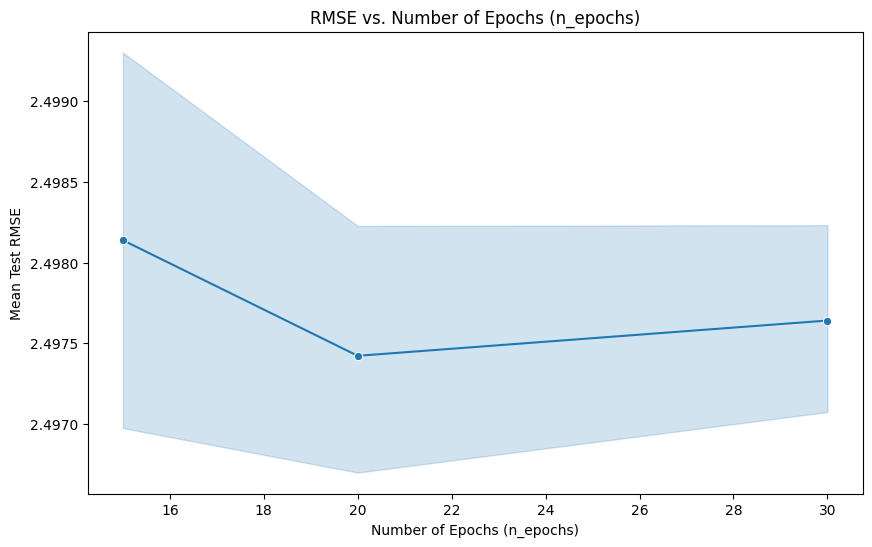

In [31]:
filtered_df = results_df[results_df['param_n_factors'] == 100] 

# Creating the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=filtered_df, x='param_n_epochs', y='mean_test_rmse', marker='o')
plt.title('RMSE vs. Number of Epochs (n_epochs)')
plt.xlabel('Number of Epochs (n_epochs)')
plt.ylabel('Mean Test RMSE')
plt.show()

`Next, let's explore the relationship between the number of factors and RMSE `

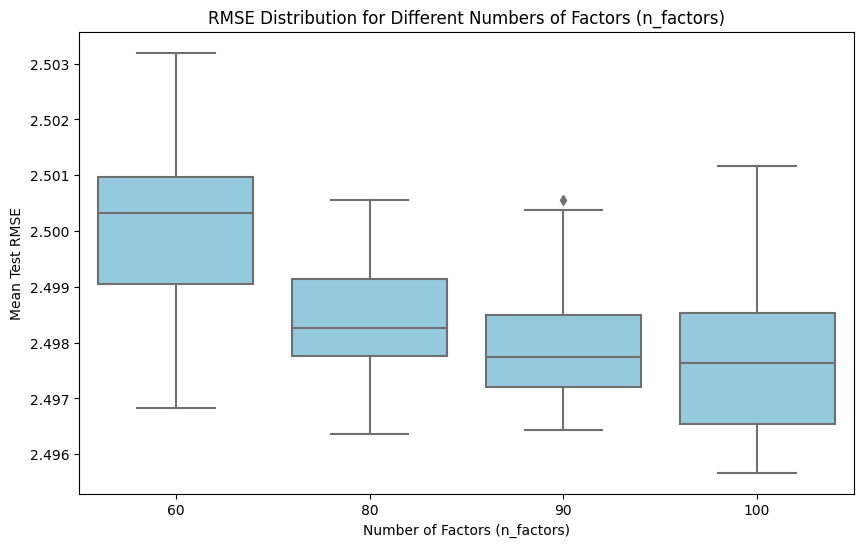

In [32]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df, x='param_n_factors', y='mean_test_rmse', color='skyblue')
plt.title('RMSE Distribution for Different Numbers of Factors (n_factors)')
plt.xlabel('Number of Factors (n_factors)')
plt.ylabel('Mean Test RMSE')
plt.show()

`Finally, let's explore the relationship between the learning rate and RMSE `

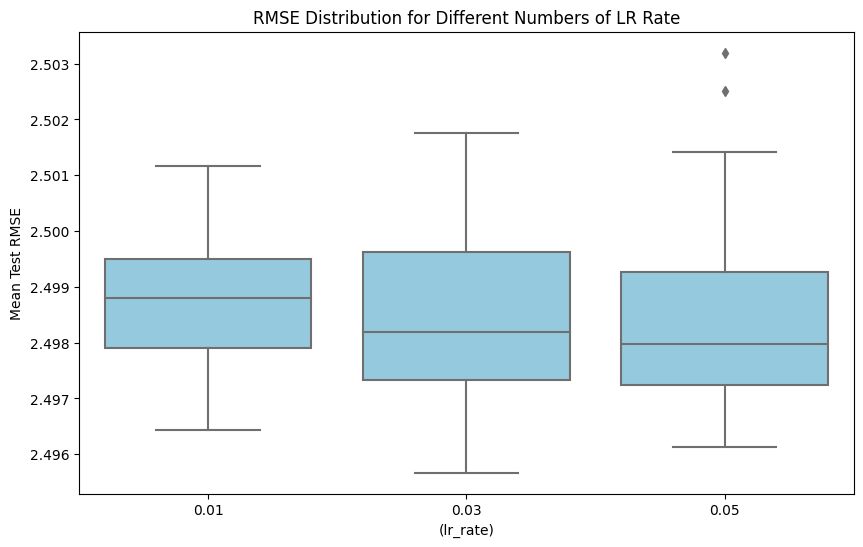

In [33]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df, x='param_lr_all', y='mean_test_rmse', color = 'skyblue')
plt.title('RMSE Distribution for Different Numbers of LR Rate')
plt.xlabel('(lr_rate)')
plt.ylabel('Mean Test RMSE')
plt.show()

`Conclusion:` It appears that increasing the number of factors and learning rate and epochs could potentially improve the model performance.  

#### 3.3.3 Last hope

It bothers me deeply to know that the hyperparameters are not optimize. I will attempt to tune the hyperparameters using GridSearchCV to get the best model performance.

In [34]:
def extend_grid_if_edge(best_param, current_grid):
    if best_param == current_grid[0]:  # Left edge
        new_edge = current_grid[0] - (current_grid[1] - current_grid[0])
        new_grid = [new_edge] + current_grid[:-1]
        action = "left"
    elif best_param == current_grid[-1]:  # Right edge
        new_edge = current_grid[-1] + (current_grid[-1] - current_grid[-2])
        new_grid = current_grid[1:] + [new_edge]
        action = "right"
    else:
        new_grid = current_grid
        action = None
    return new_grid, action

def continuous_grid_search(model, initial_param_grid, data, measures, cv):
    current_grid = initial_param_grid.copy()
    grid_updated = True
    
    while grid_updated:
        grid_updated = False  # Assume no updates until found otherwise
        
        # Perform grid search with the current grid
        grid_search = GridSearchCV(model, current_grid, measures=measures, cv=cv, n_jobs=-1)
        grid_search.fit(data)
        
        best_params = grid_search.best_params['rmse']  # Adjust based on your metric
        
        # Iterate over each hyperparameter to potentially extend the grid
        for param, best_value in best_params.items():
            original_grid = current_grid[param]
            new_grid, action = extend_grid_if_edge(best_value, original_grid)
            if action:  # If there was an extension
                current_grid[param] = new_grid
                print(f"Grid for {param} extended to the {action}. New grid: {new_grid}")
                grid_updated = True
        
        # If no grid was updated, optimization is complete
        if not grid_updated:
            print("Optimization complete. No further grid extensions needed.")
    
    return best_params


Now, we will give the function a range of hyperparameters to search over, it will shift the range left and right to find the optimal hyperparameters.

In [35]:
param_grid = {
    'n_factors': [60, 80, 90, 100],
    'n_epochs': [15, 20, 23],
    'lr_all': [0.01,0.03, 0.05],
    'reg_all': [ 0.09, 0.15, 0.2]
}

# best_params = continuous_grid_search(SVD, param_grid, data, ['RMSE', 'MAE'], 5)

# best_params

After running the function (which takes hours), These parameters yield the best RMSE
- n_factors = 140 
- n_epochs = 14
- lr: 0.03 
- reg_all: 0.4 

Thus, let's train the model on the train set and evaluate it on the test set.

In [36]:
# Use the SVD algorithm
optimized_hyperparam = {'n_factors': 140,
 'n_epochs': 14,
 'lr_all': 0.03,
 'reg_all': 0.39999999999999997}
svd_model_tuned = SVD(
    **optimized_hyperparam
)
# Train the algorithm on the trainset
svd_model_tuned.fit(trainset)


In [37]:
# evaluate the tunned SVD model 
print("Evaluating Tuned SVD Model:")
tuned_svd_metrics = ModelMetrics(svd_model_tuned, testset)
print("RMSE: ", tuned_svd_metrics.rmse)
print("MAE: ", tuned_svd_metrics.mae)


Evaluating Tuned SVD Model:
RMSE:  2.488
MAE:  1.8173


`Conclusion 3.3:` The tuned SVD model still has a higher RMSE than the baseline model. However, SVD with latent factors can help users diversify their playlist, get to discover new music taste and artists that are aligned with their preferences. This is considered more effective than just suggest the the most popular songs. 

## 4. Making Recommendations

Create a function to make recommendations for users

In [38]:
def get_top_n_recommendations(user_id, data, model, n=5):
    # 1. Identify all unique beers in the dataset
    all_songs = data.df['song_id'].unique()

    # 2. Filter out songs that the user has listened to
    song_listened = data.df[data.df['user_id'] == user_id]['song_id'].unique()
    songs_to_recommend = np.setdiff1d(all_songs, song_listened)

    # 3. Use the model to predict the ratings for these beers
    predictions = [model.predict(user_id, song).est for song in songs_to_recommend]

    # 4. Combine beers and predictions into a list of tuples and sort them
    songs_recommended = list(zip(songs_to_recommend, predictions))
    songs_recommended.sort(key=lambda x: x[1], reverse=True)

    # Return the top n beers
    return songs_recommended[:n]


`Question 1:`  For a random sample of 5 users with 10 or more song plays make 5 recommendations of songs they have not listened to with your SVD 

In [39]:
# get all the users with 10 or more song plays
user_id = merged_df[merged_df['play_count']>=10]['user_id']

# get 5 random users from the user_id list 
random_users = user_id.sample(5)

# get a unique dictionary for song_id and song
song_dict = merged_df[['song_id','song']].drop_duplicates()

song_dict = song_dict.set_index('song_id').to_dict()['song']

In [40]:
for user in random_users:
    top_songs = get_top_n_recommendations(user, data, svd_model_tuned, n=5)

    print(f"Top 5 Song Recommendations for : {user}")

    for songs_id, predicted_playcounts in top_songs:
        print(f"{song_dict.get(songs_id)}: {predicted_playcounts:.4f}")
    print("\n")

Top 5 Song Recommendations for : f045e6fb4c8519450d3503433caa611415465572
Bullet-proof Skin: 6.4567
The Hidden Hallows: 6.4407
Reptilia: 6.3714
Soulful Dress: 6.3550
Combat Chuck: 6.2813


Top 5 Song Recommendations for : cd409eba5b5adfac03e1376c118bcace962661a2
The Quest: 7.5129
Greenback Dollar: 7.5038
I Love You Always Forever ( LP Version ): 7.4911
After Hours: 7.4775
Beautiful Worlds: 7.3916


Top 5 Song Recommendations for : 190041a302d0f278da31b74c819d2874c92c26dd
Where Have All The Cowboys Gone? (Album Version): 6.0277
The Quest: 5.8532
Is it Too Late?: 5.6803
Big Jet Plane: 5.6690
I Love You Always Forever ( LP Version ): 5.6100


Top 5 Song Recommendations for : d48e4061000fad2f67b197031a8af236b77a5742
Cold Blooded (Acid Cleanse): 4.5206
Rooftop Gambler: 4.4334
The Quest: 4.3790
A Deeper Shade Of Soul: 4.3111
Project Jazz: 4.3098


Top 5 Song Recommendations for : 0de361c39b5b1a38b01dec7534b830bd943e4f2f
The Boy Does Nothing: 5.5429
Beautiful: 5.5331
Shade: 5.5236
Best Thing:

`Question 2:` Recommendation system should provide releventa recoemmendations expanding the user
s pool of option. What would you do to improve your recommendation system? 

What we can do to improve the recommendation is to improve the number of factors when building the SVD model. This will help the model to capture more complex relationships between users and items. 

`Question 3:` What are your top 10 recomemendation for a net new user? tha is a user with not user/song play count? That is a user user/song play count? Essentually the cold start problem?

- For 10 recommendations for a new user, we can recommend the 5 most popular songs (song with the most play counts) and top songs of the top 5 most popular artists (those with the most unique users).

- These songs are put in a recommendation list, and every time we have a new user, we can recommend 10 songs from this list to them

In [41]:
# Top 5 songs with the most play count 
top_songs = merged_df[['song_id','play_count']].groupby('song_id').agg({'play_count':'sum'}).reset_index()

top_songs = top_songs.sort_values(by='play_count',ascending=False)

top_songs = top_songs.head(5)

top_songs

,song_id,play_count
1400,SOAUWYT12A81C206F1,2427
2649,SOBONKR12A58A7A7E0,2384
7218,SOEGIYH12A6D4FC0E3,1680
30815,SOSXLTC12AF72A7F54,1486
9559,SOFRQTD12A81C233C0,1249


In [42]:
# revisit our top artist with the most unique listeners
artist_pop

,Artist,Total_Plays,Unique_Users
0,Coldplay,2119,858
1,Florence + The Machine,2308,600
2,Kings Of Leon,2302,583
3,Björk,2522,351
4,Dwight Yoakam,2396,290


In [43]:
# find top songs of these artists

artist_top_song = merged_df[merged_df['artist_name'].isin(artist_pop['Artist'])]

artist_top_song = artist_top_song[['artist_name','song_id','play_count']].groupby(['artist_name','song_id']).agg({'play_count':'sum'}).reset_index()

artist_top_song = artist_top_song.sort_values(by='play_count',ascending=False)

# for each of these artist, get top 2 songs 
artist_top_song = artist_top_song.groupby('artist_name').head(2)

artist_top_song['song_name'] = artist_top_song['song_id'].map(song_dict)

artist_top_song = artist_top_song[['song_id', 'song_name', 'artist_name', 'play_count']]

artist_top_song

,song_id,song_name,artist_name,play_count
0,SOAUWYT12A81C206F1,Undo,Björk,2427
86,SOBONKR12A58A7A7E0,You're The One,Dwight Yoakam,2384
130,SOSXLTC12AF72A7F54,Revelry,Kings Of Leon,1486
96,SOAXGDH12A8C13F8A1,Dog Days Are Over (Radio Edit),Florence + The Machine,982
134,SOWCKVR12A8C142411,Use Somebody,Kings Of Leon,435
47,SOKLRPJ12A8C13C3FE,The Scientist,Coldplay,345
28,SOCVTLJ12A6310F0FD,Clocks,Coldplay,294
109,SOXWYZP12AF72A42A6,Cosmic Love,Florence + The Machine,249
5,SOEIBBE12A58A7C909,Army of Me,Björk,22
88,SOECDQQ12A6D4FAE07,Pocket Of A Clown (2006 Remastered LP Version),Dwight Yoakam,6


Now that we have top 5 most play counts and top songs of the top 5 most popular artists: 
- Some songs id are overlapped, we can put them in table and shuffle them wheneve we make a recommendation for a new user.

In [44]:
cold_start_recommendation = pd.concat([artist_top_song[['song_id']], top_songs[['song_id']]])

cold_start_recommendation = cold_start_recommendation.drop_duplicates()

# add song name from song_dict
cold_start_recommendation['song'] = cold_start_recommendation['song_id'].map(song_dict)


In [71]:
# get the list of all artist and their song_id
artist_song_dict = merged_df[['artist_name','song_id']].drop_duplicates()

artist_song_dict = artist_song_dict.set_index('song_id').to_dict()['artist_name']

# add the artist name to the cold_start_recommendation
cold_start_recommendation['artist'] = cold_start_recommendation['song_id'].map(artist_song_dict)

Now make recommendations for cold start users!

In [78]:
# 10 recommendations for cold start user 
def cold_start_rec():
    rec_songs = cold_start_recommendation.sample(10)
    print('Welcome to our platform, here are 10 songs you might like: ')
    for i in range(10):
        print(f"{i+1}. {rec_songs.iloc[i]['song']} by {rec_songs.iloc[i]['artist']}")
    print("\n")
    
cold_start_rec()

Welcome to our platform, here are 10 songs you might like: 
1. You're The One by Dwight Yoakam
2. Sehr kosmisch by Harmonia
3. Pocket Of A Clown (2006 Remastered LP Version) by Dwight Yoakam
4. The Scientist by Coldplay
5. Cosmic Love by Florence + The Machine
6. Dog Days Are Over (Radio Edit) by Florence + The Machine
7. Army of Me by Björk
8. Horn Concerto No. 4 in E flat K495: II. Romance (Andante cantabile) by Barry Tuckwell/Academy of St Martin-in-the-Fields/Sir Neville Marriner
9. Revelry by Kings Of Leon
10. Clocks by Coldplay




`Question 4:` What are your top 10 recommendation for you and your peer? Do the recommendations make sense? What could you do to improve them? Do you think an item based KNN might better

In [57]:
me_and_peer = ['namtr', 'boshen']

for user in me_and_peer:
    top_songs = get_top_n_recommendations(user, data, svd_model_tuned, n=10)
    print(f"Top 10 Song Recommendations for : {user}\n")
    for songs_id, predicted_playcounts in top_songs:
        print(f"{song_dict.get(songs_id)} by {artist_song_dict.get(songs_id)}: {predicted_playcounts:.4f}")
    print("\n")

Top 10 Song Recommendations for : namtr

Roly Poly by Bob Wills And His Texas Playboys: 7.8138
Stranger by Thousand Foot Krutch: 7.5061
A Boy Without A Girl by Frankie Avalon: 7.4376
Whiskey_ You're the Devil by The Clancy Brothers: 7.3826
August Moon by Ottmar Liebert: 7.3671
Smoking Gun by The Robert Cray Band: 7.3220
Fingers Become Thumbs by Future Of The Left: 7.2997
The Time Is Now by WWE John Cena and Tha Trademarc: 7.2527
Enter The Dragon by Charlie Hunter: 7.2341
Un Dia Gris by Paulina Rubio: 7.2271


Top 10 Song Recommendations for : boshen

A Deeper Shade Of Soul by Ray Barretto: 8.1062
Un Dia Gris by Paulina Rubio: 7.9366
Come Thou Fount Of Every Blessing by Sufjan Stevens: 7.7399
Cold Blooded (Acid Cleanse) by The fFormula: 7.6264
Two Steps Down by Damnation A.d.: 7.4790
Entre Tus Alas by Camila: 7.4741
Imaginary Love by Rufus Wainwright: 7.4351
Love And Live by Ektomorf: 7.4313
Living In The White by Meneguar: 7.4111
The Quest by HYPOCRISY: 7.3959




- Our model's recommendations have been fascinating, as it introduces me to both familiar tunes and genres I rarely explore, which has been a great way to discover new music. Thus, I think the recommendations make sense.

- There are a few ways to improve our recommendation system. One way is from the model's optimization perspective. The second way is to improve the recommendation system from the user's perspective. 

- *From the model's optimization perspective*: we can further fine-tune the hyperparameters of the SVD model, by trying out different cross validation sizes, or attempt to add model features to the model. Additional features might capture important aspects fo the data not reflected in teh original matrix. For instance, incoporating user or item metadata (age, genre, etc) could provide more signals for the model to learn from

- *From the user's perspective*: it depends on where the users would like there recommendations to be more personalized or more diverse. If the user prefers more personalized recommendations, we can increase the number of factors in the SVD model so that the model can capture more complex relationships between users and items. On the other hand, decreasing the numeber of latent factors can help users diversify their playlist, get to discover new music taste and artists as model will tend to make broader, less specific recommendations

- Item based KNN might not be better our current model due to various reasons. First, KNN is computationally expensive and slow. Second, KNN is not scalable. As the number of users and items grow, the computation time and memory requirements grow dramtically. Third, it is the lack of diversity in the recommendations. KNN tends to recommend the most popular items or items that are similar to the user's most popular items. Thus, it is not effective in helping users discover new music taste and artists that are aligned with their preferences.